In [58]:
DEBUG = False
CONFIG_FILE = '/datascope/subaru/data/targeting/MW/outerdisk_l180_b22_ENG/netflow/outerdisk_l180_b22_faint_004/ga-netflow_20250123033847.cmd'
OUTPUT_PATH = '/datascope/subaru/data/targeting/MW/outerdisk_l180_b22_ENG/netflow/outerdisk_l180_b22_faint_004/'

# Plot the design files

In [59]:
import os, sys, re
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

In [60]:
plt.rc('font', size=6) #controls default text size

In [61]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
if DEBUG and 'debug' not in globals():
    import debugpy
    debugpy.listen(('0.0.0.0', int(os.environ['PFS_TARGETING_DEBUGPORT'])))
    debug = True

# Imports

In [63]:
import pfs.utils
from pfs.datamodel import PfsDesign, FiberStatus, TargetType

from pfs.ga.targeting.scripts.netflow.notebooks.notebooks import *
from pfs.ga.targeting.instrument import *
from pfs.ga.targeting.util.astro import *

# Load the netflow config file

In [64]:
# Load the configuration
config = load_netflow_config(CONFIG_FILE)

2025-01-22T22:49:36.665 30 cobraCoach setting invisible cobras: [173, 648, 799, 853, 949, 1173, 1653, 1724, 2182]
2025-01-22T22:49:36.697 30 cobraCoach setting bad cobras: [47, 50, 173, 193, 344, 347, 361, 443, 493, 648, 738, 754, 799, 821, 853, 949, 1150, 1173, 1208, 1210, 1303, 1460, 1494, 1520, 1539, 1580, 1637, 1653, 1724, 1790, 1791, 1792, 1825, 1836, 1882, 1903, 2053, 2182, 2352, 2380]
2025-01-22T22:49:36.704 20 cobraCoach cc connecting to fpga....
2025-01-22T22:49:36.706 30 butler     newRun: /tmp/cobra_coach/20250122_239


JSONLibraryException: JSON Library Exception

Exception thrown by library (json): [4;37m('Unable to parse text', 'ga-netflow --config ./configs/netflow/ENG/MW/outerdisk_common.py ./configs/netflow/ENG/MW/outerdisk_l180_b22_faint.py --out /datascope/subaru/data/targeting/MW/outerdisk_l180_b22_ENG/netflow/outerdisk_l180_b22_faint_004 --obs-time 2025-01-24T10:00:00 --nvisits 1 --no-nan-values\n')[0m

    Traceback (most recent call last):
      File "/datascope/slurm/miniconda3/envs/dobos-torch/lib/python3.10/site-packages/commentjson/commentjson.py", line 180, in loads
        parsed = _remove_trailing_commas(parser.parse(text))
      File "/datascope/slurm/miniconda3/envs/dobos-torch/lib/python3.10/site-packages/lark/lark.py", line 311, in parse
        return self.parser.parse(text, start=start)
      File "/datascope/slurm/miniconda3/envs/dobos-torch/lib/python3.10/site-packages/lark/parser_frontends.py", line 89, in parse
        return self._parse(token_stream, start, *[sps] if sps is not NotImplemented else [])
      File "/datascope/slurm/miniconda3/envs/dobos-torch/lib/python3.10/site-packages/lark/parser_frontends.py", line 54, in _parse
        return self.parser.parse(input, start, *args)
      File "/datascope/slurm/miniconda3/envs/dobos-torch/lib/python3.10/site-packages/lark/parsers/lalr_parser.py", line 36, in parse
        return self.parser.parse(*args)
      File "/datascope/slurm/miniconda3/envs/dobos-torch/lib/python3.10/site-packages/lark/parsers/lalr_parser.py", line 84, in parse
        for token in stream:
      File "/datascope/slurm/miniconda3/envs/dobos-torch/lib/python3.10/site-packages/lark/lexer.py", line 373, in lex
        for x in l.lex(stream, self.root_lexer.newline_types, self.root_lexer.ignore_types):
      File "/datascope/slurm/miniconda3/envs/dobos-torch/lib/python3.10/site-packages/lark/lexer.py", line 174, in lex
        raise UnexpectedCharacters(stream, line_ctr.char_pos, line_ctr.line, line_ctr.column, allowed=allowed, state=self.state, token_history=last_token and [last_token])
    lark.exceptions.UnexpectedCharacters: No terminal defined for 'g' at line 1 col 1
    
    ga-netflow --config ./configs/netflow/EN
    ^
    
    Expecting: {'LBRACE', 'FALSE', 'TRUE', 'LSQB', 'SIGNED_NUMBER', 'ESCAPED_STRING', 'NULL'}
    
    
    During handling of the above exception, another exception occurred:
    
    Traceback (most recent call last):
      File "/datascope/slurm/miniconda3/envs/dobos-torch/lib/python3.10/site-packages/commentjson/commentjson.py", line 215, in load
        return loads(fp.read(), **kwargs)
      File "/datascope/slurm/miniconda3/envs/dobos-torch/lib/python3.10/site-packages/commentjson/commentjson.py", line 183, in loads
        raise ValueError('Unable to parse text', text)
    ValueError: ('Unable to parse text', 'ga-netflow --config ./configs/netflow/ENG/MW/outerdisk_common.py ./configs/netflow/ENG/MW/outerdisk_l180_b22_faint.py --out /datascope/subaru/data/targeting/MW/outerdisk_l180_b22_ENG/netflow/outerdisk_l180_b22_faint_004 --obs-time 2025-01-24T10:00:00 --nvisits 1 --no-nan-values\n')
    

# Plot the design files

In [43]:
# Create the PFI instrument. This will load the instrument calibration data.
pfi = SubaruPFI(instrument_options=config.instrument_options)

2025-01-22T21:09:21.929 30 cobraCoach setting invisible cobras: [173, 648, 799, 853, 949, 1173, 1653, 1724, 2182]
2025-01-22T21:09:21.965 30 cobraCoach setting bad cobras: [47, 50, 173, 193, 344, 347, 361, 443, 493, 648, 738, 754, 799, 821, 853, 949, 1150, 1173, 1208, 1210, 1303, 1460, 1494, 1520, 1539, 1580, 1637, 1653, 1724, 1790, 1791, 1792, 1825, 1836, 1882, 1903, 2053, 2182, 2352, 2380]
2025-01-22T21:09:21.976 20 cobraCoach cc connecting to fpga....
2025-01-22T21:09:21.980 30 butler     newRun: /tmp/cobra_coach/20250122_125


In [44]:
# Find and load the design files in the output directory
designs = {}
design_files = glob(os.path.join(OUTPUT_PATH, 'pfsDesign*.fits'))
for fn in design_files:
    pfsDesignId = int(re.search(r'0x[0-9a-f]+', fn).group(0), 16)
    design = PfsDesign.read(pfsDesignId, dirName=os.path.dirname(fn))
    designs[pfsDesignId] = design
    print(f'Loaded design 0x{pfsDesignId:016x}')

Loaded design 0x6802217989892921


In [45]:
# Verify that there are no duplicate fiberIds
for pfsDesignId, design in designs.items():
    counts = np.bincount(design.fiberId)
    print(f'0x{pfsDesignId:016x}', np.where(counts > 1))

0x6802217989892921 (array([], dtype=int64),)


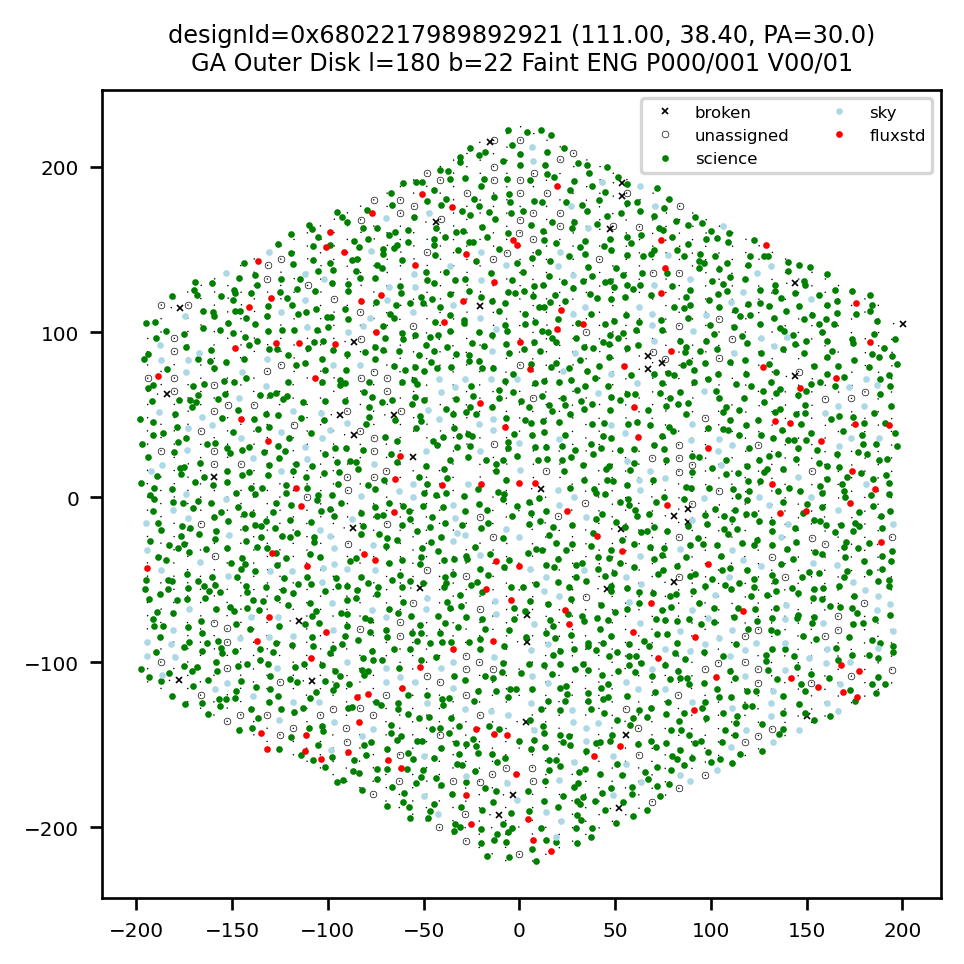

In [65]:
for pfsDesignId, design in designs.items():
        f, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=240)

        # Broken cobras or fibers
        mask = (design.fiberStatus != FiberStatus.GOOD)
        ax.plot(design.pfiNominal[mask][..., 0], design.pfiNominal[mask][..., 1], 'x', ms=2, label='broken',
                color='black', markeredgewidth=0.5)

        # Unassigned good cobras
        mask = (design.fiberStatus == FiberStatus.GOOD) & (design.targetType == TargetType.UNASSIGNED)
        ax.plot(design.pfiNominal[mask][..., 0], design.pfiNominal[mask][..., 1], 'o', ms=2, label='unassigned',
                markerfacecolor='none', markeredgecolor='black', markeredgewidth=0.2)

        # Good science targets
        mask = (design.fiberStatus == FiberStatus.GOOD) & (design.targetType == TargetType.SCIENCE)
        ax.plot(design.pfiNominal[mask][..., 0], design.pfiNominal[mask][..., 1], 'o', ms=1, label='science', color='green')

        # Good sky fibers
        mask = (design.fiberStatus == FiberStatus.GOOD) & (design.targetType == TargetType.SKY)
        ax.plot(design.pfiNominal[mask][..., 0], design.pfiNominal[mask][..., 1], 'o', ms=1, label='sky', color='lightblue')

        # Good flux standards
        mask = (design.fiberStatus == FiberStatus.GOOD) & (design.targetType == TargetType.FLUXSTD)
        ax.plot(design.pfiNominal[mask][..., 0], design.pfiNominal[mask][..., 1], 'o', ms=1, label='fluxstd', color='red')

        # Cobra centers
        ax.scatter(pfi.bench.cobras.centers.real, pfi.bench.cobras.centers.imag, 
                   s=0.2, color='black', edgecolors='none')

        ax.set_title(
                f'designId=0x{pfsDesignId:016x} ({design.raBoresight:0.02f}, {design.decBoresight:0.02f}, PA={design.posAng:0.01f})\n'
                f'{design.designName}')

        # Make legend horizontal
        ax.legend(loc='upper right', ncol=2, fontsize='small')

        f.tight_layout()

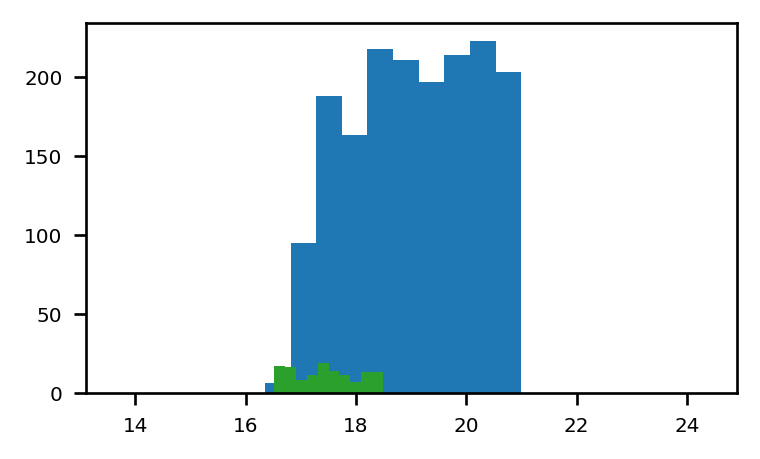

In [47]:
cmap = plt.get_cmap('tab10')

for pfsDesignId, design in designs.items():
    f, ax = plt.subplots(1, 1, figsize=(3.5, 2), dpi=240)
    for j, target_type in enumerate([TargetType.SCIENCE, TargetType.SKY, TargetType.FLUXSTD]):
        idx = np.where((design.fiberStatus == FiberStatus.GOOD) & (design.targetType == target_type))[0]
        flux = np.array([ design.fiberFlux[i][0] for i in idx if len(design.fiberFlux[i]) > 0 ])
        mag = nJy_to_ABmag(flux)
        
        ax.hist(mag, color=cmap(j), label=target_type)
        
    ax.set_xlim(13.1, 24.9)

In [49]:
# Unique catIds
for pfsDesignId, design in designs.items():
    print(f'0x{pfsDesignId:016x}', np.unique(design.catId))

0x6802217989892921 [   -1  1007  3006 10088]


In [ ]:
# Unique proposalIds
for pfsDesignId, design in designs.items():
    print(f'0x{pfsDesignId:016x}', np.unique(design.catId))

0x6802217989892921 [   -1  1007  3006 10088]


In [69]:
# objId ranges
for pfsDesignId, design in designs.items():
    for target_type in [TargetType.SCIENCE, TargetType.SKY, TargetType.FLUXSTD]:
        mask = (design.fiberStatus == FiberStatus.GOOD) & (design.targetType == target_type)
        print(f'0x{pfsDesignId:016x}', target_type, design.objId[mask].min(), design.objId[mask].max())

0x6802217989892921 SCIENCE 153281109472951425 3608524950807355392
0x6802217989892921 SKY 3526618525 3533845635
0x6802217989892921 FLUXSTD 680271205 682377971
